# Pandas性能优化


如果需要性能优化，首先需要了解一些计时的命令，除了前后各加一个time.time()做差之外（多数情况下这并不能满足你重复进入其中某一个函数以计时的需求），可以尝试搜索以下命令的使用: %time,%timeit,%%time,%%timeit,%prun,%lprun,tqdm。

需要强调%lprun需要额外安装包，以及timeit不是执行一次计时，而是执行多次之后给一个统计量。使用单个 % 开头的魔法命令作用于单行，而 %% 开头的命令则作用于整个Jupyter格。tqdm会显示一个类似进度条的东西。

理想情况下，你可以巧妙地将你的代码不断封装成函数，使用%lprun，最终查出是哪一条命令花费了太长的时间，是否可以优化。

此外，我还找到一些NumExpr等加速科学运算的方式，详见

https://cloud.tencent.com/developer/article/1652512

NumExpr支持在表达式中使用大量的数学运算符，但不支持条件运算符，如 if 或 else。

常见的pandas优化加速教程中都会使用如下的说法

1、直接使用索引直接遍历数据框

2、使用iterrows进行循环

3、使用apply循环

4、Pandas序列的矢量化

5、NumPy链表的矢量化


这样的说法固然很明白，但是我不太清楚为什么

- 提到apply的时候不顺便提一嘴parallel apply
- 这样的说法没有区分你进行的运算到底是什么目的，它给你一种错觉，任何一种循环都可以以上面五种方式实现，而且顺序是1-5逐渐变优。

以及如果要一行一行递出去数据


我计划分两部分来学习这些内容。

首先从数据结构而言，应该尽可能避免将dataframe生成某种迭代器频繁地访问其中某一个元素，如果是这样的需求，建议使用字典（字典好于列表）。这样的需求在数据分析任务中不是很常见，更常见的是在工程性地实时处理的工作中，例如你需要回放式地回测一个量化的策略，你需要将一天的数据通过一个迭代器一条一条传入。此时最建议的办法是使用pandas读入数据之后转化为字典序列，再每次传入字典，需要存储时使用pd.DataFrame.from_dict(xx)转化为pandas进行存储。如果是一个需要经常被访问的数据，值得专门存储这个序列，可以使用pickle。此外numpy在生成迭代器方面也表现不错，如果善于处理numpy，可以使用to_numpy代替to_dict。下面这篇文章（找不到他翻译的原文。。）除了可能看不到图片之外，比较详细地介绍了如何在dataframe上利用迭代器（索引和iterrows），以及何时应该将其改为apply的循环。

https://python.freelycode.com/contribution/detail/1083

其核心结论如下

1、避免使用循环；循环的执行速度慢，有时候还很不必要；

2、不得不使用循环时，使用apply() 方法，而不是循环调用函数；

3、矢量化比使用标量操作更好。Pandas中大多数的操作都可以被矢量化。

4、NumPy arrays上的矢量化操作要比Pandas series更高效。

这篇文章介绍了如何通过一些小技巧使用numpy代替pandas运算，获得更高的性能
https://cloud.tencent.com/developer/article/1994580?from=article.detail.1652512

或许有用
https://developer.aliyun.com/article/870649

In [2]:
import pandas as pd
import pickle
#The comparison of Method 1 and 2 shows that dictionary generator is faster by reducing time to use iloc()

def prepare_data(data:pd.DataFrame):
    d1=data.to_dict(orient='records')
    file=open('save.pkl',"wb")
    pickle.dump(d1,file) #保存list到文件
    file.close()
    
def generate_tick_data_from_loading_pkl():
    file=open('save.pkl',"rb")
    data=pickle.load(file) #读取文件到list
    for snapshot in data:
        yield snapshot

#method1
for x in generate_tick_data_from_loading_pkl():  #x is dict
    algo(x)

#method2
for i,xx in data.iterrows():
    x=dict(xx[1])    
    algo(x)
    
#method 3
for i in range(len(data)):
    x=data.iloc[i].to_dict()
    algo(x)

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()
%%time
sum1=0
for row in tqdm(df.values):
    sum1+=row[1]*row[2]

## numba

python之所以慢，是因为它是靠CPython编译的，numba的作用是给python换一种编译器。使用非常简单，在自定义的函数前面塞一句jit就可以。

numba有一个不太好用的地方在于你需要把@numba这句放在你定义的需要大量for循环的内容之前，所以你必须得把你要循环的东西封装成一个函数.

Numba还有另外一个问题就是，如果你封装的函数里面用了ipython之类的玩意，会被报错（cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>），猜测是因为这种比较复杂的数据结构不适合传给C。这意味着你不可以在numba中使用任何dataframe

所以就是说，numba必须作用在用最淳朴的数据结构上使用的大量循环，这也决定了它的使用其实会收到一些限制而常常被忘记。例如，如果你试图在pandas上直接使用numba，你必须把他转化为numpy array，而多数可以这样做的操作，已经被pandas矢量化了，因此你会发现一旦你可以使用numba，你大概也可以直接矢量化（这应该多数情况下是最快的）

In [9]:

import pandas as pd

import numba  

def cal_sum(a): 
    result = 0 
    for i in range(a.shape[0]): 
        for j in range(a.shape[1]): 
            result += a[i, j] 
    return result 
import numpy as np
a = np.random.random((500, 500)) 
%timeit cal_sum(a) 

 
@numba.jit(nopython=True) 
def cal_sum1(a): 
    result = 0 
    for i in range(a.shape[0]): 
        for j in range(a.shape[1]): 
            result += a[i, j] 
    return result 

a = np.random.random((500, 500)) 
%timeit cal_sum1(a) 


@numba.jit(nopython=True) 
def cal_sum2(a): 
    result = 0 
    for i in range(500): 
        for j in range(500): 
            result += data.loc[i, j] 
    return result 

data=pd.DataFrame(np.random.random((500, 500)) )

#try_this?
# %timeit cal_sum2(data) 

81.2 ms ± 768 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
232 µs ± 3.46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
#将pandas与numba结合
import numba
import time
@numba.vectorize
def f_with_numba(x): 
    return x * 2

def f_without_numba(x): 
    return x * 2
time1=time.time()
#方法一：apply逐行操作
df1["score2_1"] = df.score.apply(f_without_numba)  # 1.515336275100708
print(time.time()-time1)
time1=time.time()
#方法二：向量化运行
df["score2_2"] = df.score*2  #0.010433197021484375
print(time.time()-time1)
#方法三：运用numba加速
#需要以numpy数组的形式传入
#否则会报错
time1=time.time()
df["score2_3"] = f_with_numba(df.score.to_numpy())
print(time.time()-time1)   # 0.04761838912963867

# 可并行循环的加速：并行运算相关

这一章节的东西不要求任何并行的基础操作，我自己也没有学过相关的课程。我们追求的是如何用最简单的命令，做最少的改动（而不是整个重写成接口给别的函数调用），能够使我们做的分析得到加速（虽然计算复杂度不关心常数倍，节省一半时间也是节省，不是吗？）。

所谓的可以并行的循环，我想说的是一些每个循环的单元不需要依赖前面单元的结果的情形。多数情况下你会发现你所使用的for循环，你将列表重新换个顺序也不影响结果，你需要的只是对其中每一个元素做类似的独立操作。类似的，如果你想使用dataframe的其中几列数据计算新的一列数据，而这个运算将要遍历很多行，那么这也是一种重复的操作。

暂时不考虑手动用矩阵改写乘法这种神仙操作，开多线程的教程网上很多，但我也没怎么用过。
除此之外我所接触到的加速手段主要是使用numba，pandas的apply和parallel apply。


## apply

并不重要的问题是apply是否算是并行运算（事实上apply也是逐条读的，但是他用了CPython等更好的迭代器进行过全局优化所以速度更快。但是，不可以用apply进行跨行操作（例如，apply一个函数，需要用到上一行的数据），这一特点使得它多数情况下不像是我们常规意义上有顺序的循环）。我们只关心，对于一个dataframe，如果可以apply，那么速度会快于逐行进行运算,尤其是当你的计算资源足够而数据本身很大时，这一优势会非常明显。

In [18]:
data=pd.DataFrame(np.random.random((500,500)) )
#--row_by_row-
def cal_row_sum(data):
    for i in data.index:
        data.loc[i,'row_sum']= data.loc[i].sum()
%timeit cal_row_sum(data)
#--apply--
def sum_row(x):
    return x.sum()
def cal_row_sum2(data):
    data.loc['row_sum']= data.apply(sum_row)
%timeit cal_row_sum2(data)

139 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
49.8 ms ± 780 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


这也是我认为有必要将与并行相关的地方单独提出来的原因之一。如果我们承认在处理dataframe时apply明显快于逐行的循环，而你的任务本身确实不依赖先后顺序，而且你对每行将要进行的运算可以用**一行** （而不是在一个列表中插进去一个数字，或者生成一个dataframe）的数据记录下来（最简单的情形比如我用两列算出几列新的数据，类似下面的row_sum），那么我们的出发点就应该是想办法让输入和输出变成一个dataframe （为了强调，我们可以叫他guider），然后apply一个函数。这个函数接受guider中每一行的几个列作为输入，又吐出对应的几个数作为输出。同时可以任意复杂，比如可以去别的dataframe中读数据，再apply一些新的复杂功能，然后返回几个你需要的数字。目前唯一让我感觉不能使用这种方法加速运算的，是如果我要从guider中的几行通过函数得到一个新的dataframe，然后再将它们通过类似pd.concat的方法并起来。不过依然可以的是分别存到一个文件夹，通过os.listdir()知道文件夹下的所有pkl，再读进来并。

简单的这么说或许只能传达“apply比for循环快”这一无聊的信息。为了表达我的观点，可以尝试以下例子
(造数：https://zhuanlan.zhihu.com/p/390337265)

In [27]:
import pandas as pd
import numpy as np

df1 = pd.DataFrame(np.random.randint(0,5,size=(10000, 1)),columns=['test']) # 生成0，1序列，并指定名称为'test'
df1['weekday'] = pd.DataFrame(np.random.randint(1,7,size=(10000, 1))) # 生成0，1序列，并指定名称为'test'
df1

,test,weekday
0,3,6
1,4,4
2,0,1
3,1,5
4,4,5
...,...,...
9995,1,4
9996,1,3
9997,3,5
9998,4,5


## parallel apply

大多数情况下apply本身已经挺快的，如果apply还是很慢的话（行数特别多，比如上千万级别），可以考虑使用 pandarallel，用法非常简单，只需要import包，初始化这个对象，然后将所有apply换成parallel_apply。如果想看到进度条从0开始长的图像，可以把progress_bar 设置为True，你会看到你的任务条数被几乎均等的分配到你电脑能提供的workers上，每个进度条都代表一个worker完成了多少它该计算的部分。经过较多的使用，有两点值得提醒

- 在数据量不会很大的情况下，表现一般，甚至不如apply。（不太严谨的）apply要花很久才能跑完的巨大运算，parallel反而可能有奇效，当然这取决于你的计算资源可以提供多少worker。（网传）如果调用的函数本身不是很复杂，效果也不会很明显。

- 如果parallel_apply的函数有问题，它报错的方式不是告诉你调用函数哪里出了问题，而是会产生类似ran out of input或者EOF的错误。所以用之前最好先debug好。推荐的方式为
    - apply一小块先试一下
    - 将函数调用在dataframe.iloc[num]上看看

In [20]:
from pandarallel import pandarallel 
pandarallel.initialize(progress_bar=False)


data=pd.DataFrame(np.random.random((50000,50000)) )


%timeit cal_row_sum2(data)

def cal_row_sum3(data):
    data.loc['row_sum']= data.parallel_apply(sum_row)
    
%timeit cal_row_sum3(data)

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
1min 43s ± 469 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 15s ± 1.93 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
import numpy as np
import pandas as pd
data = np.random.randint(0,100,size = (2**16, 2**4))
df = pd.DataFrame(data)
df = df.add_prefix("Col:")
df

,Col:0,Col:1,Col:2,Col:3,Col:4,Col:5,Col:6,Col:7,Col:8,Col:9,Col:10,Col:11,Col:12,Col:13,Col:14,Col:15
0,77,62,88,65,33,34,59,75,99,94,30,3,64,7,13,85
1,50,36,75,46,37,3,12,47,93,34,71,75,68,81,50,83
2,33,40,25,17,40,87,87,63,17,89,73,87,10,26,99,66
3,56,22,27,18,5,17,39,96,20,25,13,88,21,49,1,86
4,97,31,18,23,57,85,89,77,86,75,40,76,62,44,92,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,84,92,42,20,96,70,48,31,43,37,61,50,84,9,82,32
65532,59,36,29,40,61,48,21,31,26,28,84,41,7,55,41,58
65533,49,64,46,71,23,12,43,16,78,88,24,13,96,9,97,5
65534,44,22,66,73,65,88,95,84,7,90,93,39,74,23,48,43


# 时间相关
## 不同时间格式的转化
## resample

In [ ]:
def to_4digit_int(ttime1:int)->int:
    ttime=int(ttime1/1000000000.0)
    t=time.localtime(ttime)
    ttime=t.tm_hour*100+t.tm_min
    return ttime

# 一些永远搞不清楚的定义

## 凹凸性，上凸下凸
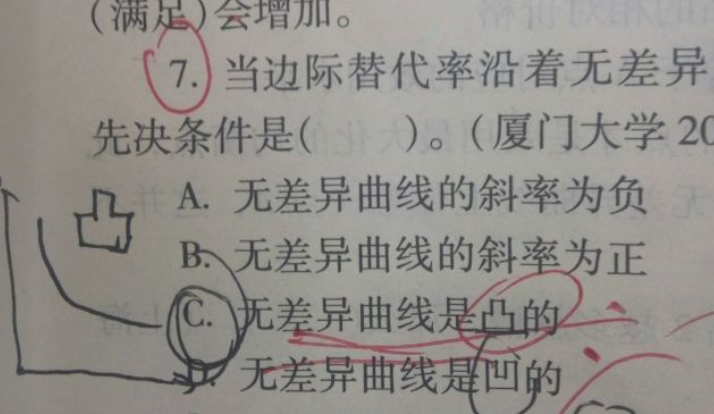

## (行,列）还是(列,行)

## 左偏右偏（拖尾还是偏峰？）

# JupyterNotebook可能遇到的一些问题
## 太长的循环，跑到一半*号消失了？
## 突然cell停止输出？你问他1+1？

# Python画图相关

# DataFrame的索引
## loc与iloc
## index，时间索引

# 或许还不错的命令
## Groupby
## pivot
## query
## 



# 最优化相关

# 统计相关
## np.random生成随机数与分布拟合
## faker 数据伪造
## 分布的估计



# 画图相关

多数情况下似乎没有一个统一而标准的说法告诉你什么东西可以.plot，什么情况下plot/hist的参数中可以带着类似标题和图例之类的参数，我感觉没什么好办法容易记住，只能随用随查，多数情况下去搜以下想用的画图命令(比如dataframe.hist()和plt.hist())，执行一遍别人的命令基本就看得懂。唯一有必要在此处说明的是，如果你尝试添加图例，但图例并没有成功的显示在你的图例，你或许要考虑一个叫句柄的东西。简而言之，下图的例子中l1,如果换成了l1=，你的图例或许就显示不出来，但你要是认为这是个tuple，用两个变量去接返回值，例如用l1,m=plt.plot()，它会告诉你没有足够的东西给你解析给两个变量。我认为出于实用的目的可以不需要知道什么是句柄，只需要知道如果图例显示有问题，查一下是不是报错的时候提到了你需要用handler，是否加一个逗号就可以解决。

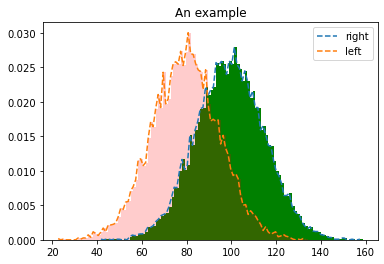

In [47]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19260801)

#用来显示中文标签

plt.rcParams['font.sans-serif'] = ['SimHei']
#用来正常显示负号
plt.rcParams['axes.unicode_minus']=False 

mu1, sigma1 = 100, 15
mu2, sigma2 = 80, 15
x1 = np.random.normal(mu1,sigma1,10000) # (均值,方差/标准差,个数)
x2 = np.random.normal(mu2,sigma2,10000)

n1, bins1, patches1 = plt.hist(x1, bins=100, density=True,color='g', alpha=1)
n2, bins2, patches2 = plt.hist(x2, bins=100, density=True,color='r', alpha=0.2)

l1,=plt.plot(bins1[:-1],n1,'--')
l2,=plt.plot(bins2[:-1],n2,'--')
# plt.show()
plt.legend(handles=[l1,l2],labels=['right','left'],loc='best')
plt.title('An example')
plt.show()

/opt/Anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

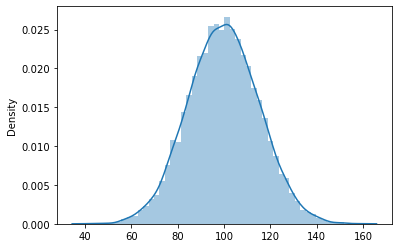

In [49]:
import seaborn as sns
sns.distplot(x1)

1.2 P-P图及Q-Q图  https://zhuanlan.zhihu.com/p/358387201

直方图是最长用于观察数据分布的常用图形选项，尤其是带正态曲线的直方图，可以非常直观地看到实际数据分布和正态曲线的对比，而P-P图及Q-Q图则是另一种选择，它可以直观给出实际数据分布和理论的差距。

值得注意的是，虽然P-P图及Q-Q图常用用于判断数据样本是否服从正态分布，但实际上它们也能判断数据样本是否服从其他的分布

1.2.1 P-P图

P-P图反映的是数据的实际累积概率与假定所服从分布的理论累积概率的符合程度。在此处，我们所假定的分布就是正态分布，如果数据样本是服从正态分布的话，那么实际的累积概率与理论的累积概率应该是相对一致的，放映在图形中就是数据点应该沿着图形的对角线分布。

1.2.2 Q-Q图

Q-Q图的原理与P-P图几乎一致。P-P图考察的是实际分布与理论分布的累积概率分布差异，而Q-Q图考察的是实际百分位数与理论百分位数的差异。同理在此处，我们所假定的分布就是正态分布，如果数据样本是服从正态分布的话，那么实际的分布应该是相对一致的，反映在图形中就是数据点应该沿着图形的对角线分布。

在Python中，statsmodels包中目前主要提供的是Q-Q图的绘制，代码如下：


## 统计
图形观察虽然直观，但是部分研究者认为单纯观察图形过于主观，因此我们也可以选择使用统计检验的方法去研究数据是否服从正态分布。

在日常使用当中，最常用的正态性检验方法有K-S检验及W检验。

2.1 K-S检验

柯尔莫戈洛夫-斯米诺夫检验（Kolmogorov-Smirnov test），一般又称K-S检验，该检验是柯尔莫戈洛夫所提出的，是一种基于累计分布函数的非参数检验，用以检验两个经验分布是否不同或一个经验分布与另一个理想分布是否不同。

需要注意的是，K-S检验的原假设是“样本数据来自的分布与正态分布无显著差异”，因此一般来说，检验结果P>0.05才是我们的目标。

### Scipy 的正态性检验
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.normaltest.html

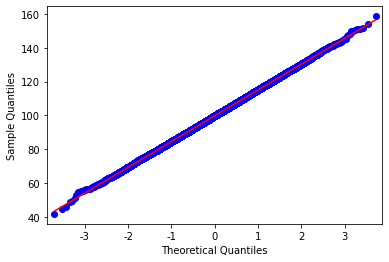

In [51]:
import statsmodels.api as sm
import pylab
sm.qqplot(x1, line='s')
pylab.show()

In [57]:
from scipy.stats import kstest
from scipy.stats import shapiro
#cdf中可以指定要检验的分布，norm表示我们需要检验的是正态分布
#常见的分布包括norm,logistic,expon,gumbel等


    
x1 = np.random.normal(mu1,sigma1,2000)

print(kstest(x1,cdf = "norm"))
print(shapiro(x1))

KstestResult(statistic=1.0, pvalue=0.0)
ShapiroResult(statistic=0.9991880655288696, pvalue=0.5382401943206787)


In [59]:
import scipy
scipy.stats.normaltest (x1, axis=0)

NormaltestResult(statistic=0.702031536674525, pvalue=0.7039726532898818)

In [61]:
k1=scipy.stats.kurtosistest (x1, axis=0)
k1

KurtosistestResult(statistic=-0.6364615490991904, pvalue=0.5244756350577845)

In [62]:
s1=scipy.stats.skewtest (x1, axis=0)
s1

SkewtestResult(statistic=-0.5449295671853234, pvalue=0.5858019599703554)

In [64]:
k1[0]**2+s1[0]**2

0.702031536674525